# IL HW3
## Part 2 | MAZE
Ali Saeizadeh
810196477

## Libraries 

In [1]:
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
import pandas as pd
import numpy as np
from random import randint
from pprint import pprint
import matplotlib.pyplot as plt
import pickle



## Map

In [2]:
map_df = pd.read_csv('maze.map', header=None)
map = map_df.to_numpy()
print(map)

[[2 1 1 1 1 1 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 1 1 1 1 1 1 1 1]]


## Environment

In [3]:
class Environment(EnvironmentBase):
    def __init__(self, obstacle=[], id=0, action_count=9, actionPrice=-0.01, goalReward=1000, punish=-1, j_limit=15, i_limit=15, p=0.8, container=None):
        map_df = pd.read_csv('maze.map', header=None)
        self.map = map_df.to_numpy()
        self.actions_name = np.array(
            ['up', 'down', 'left', 'right', 'upright', 'upleft', 'downleft', 'dwonright', 'remain'])
        self.actions = np.array([np.array([0, 1]), np.array([0, -1]), np.array([-1, 0]), np.array(
            [1, 0]), np.array([1, 1]), np.array([-1, 1]), np.array([-1, -1]), np.array([1, -1]), np.array([0, 0])])
        self.A = list(range(0, self.actions.shape[0]))
        self.S = list(range(0, self.map.size))
        self.i_limit = 15
        self.j_limit = 15
        self.p = p
        self.goal_reward = goalReward
        self.punish = punish
        self.action_price = actionPrice
        self.current_action = 0
        self.current_state = np.array([14, 14])
        self.agent_action_rec = []
        self.agent_states = [self.current_state]

    def isStatePossible(self, state):
        if(state[0] >= self.i_limit or state[0] < 0):
            return False
        if(state[1] >= self.j_limit or state[1] < 0):
            return False
        if(map[state[0], state[1]] == 0):
            return False
        return True

    def isAccessible(self, state, state_p):
        if(self.isStatePossible(state_p) == False):
            return False
        if (np.linalg.norm(state - state_p) - np.sqrt(2) > 0):
            return False
        return True

    def is_obstacle(self, state):
        if(map[state[1], state[0]] == 0):
            return True
        return False

    def number_of_accessible(self, state):
        num = 0
        for i in range(len(self.actions)):
            if(self.isStatePossible(state + self.actions[i])):
                num += 1
        return num

    def getTransitionStatesAndProbs(self, state, action, state_p):
        if(self.isAccessible(state, state_p) == False):
            return 0
        if(np.array_equal(state_p - state, self.actions[action])):
            return self.p
        else:
            return (1 - self.p) / self.number_of_accessible(state)

    def getReward(self, state, action, state_p):
        if(self.isAccessible(state, state_p) == False):
            return self.punish
        if(self.map[state_p[0], state_p[1]] == 2):
            return self.goal_reward + self.action_price
        if(self.is_obstacle(state_p)):
            return self.punish + self.action_price
        return self.action_price

    def sample_all_rewards(self):
        return

    def calculate_reward(self, action):
        # replaced by getReward
        return

    def terminated(self):
        S = self.available_states()
        if(np.array_equal(self.current_state, np.array([0, 0]))):
            return True
        return False

    def observe(self):
        return {}

    def available_actions(self):
        return self.actions

    def possible_actions(self, state):
        poss_actions = np.zeros(len(self.A))
        for a in self.A:
            state_p = state + self.actions[a]
            if(self.isStatePossible(state_p)):
                poss_actions[a] = 1
        return poss_actions

    def possible_states(self, state):
        poss_states = np.zeros(len(self.S))
        all_states = self.available_states()
        for s in self.S:
            if(self.isAccessible(state, all_states[s])):
                poss_states[s] = 1
        return poss_states

    def available_states(self):
        states = [np.array([x, y]) for x in range(self.map.shape[0])
                  for y in range(self.map.shape[1])]
        counter = list(range(0, len(states)))
        S = dict(zip(counter, states))
        return S

    def next_state(self, action):
        choise = np.random.uniform(0, 1)
        error_action = self.A.copy()
        error_action.remove(action)
        if(choise > self.p):
            action = np.random.choice(error_action)
        
        state_p = self.current_state + self.actions[action]
        if(self.isAccessible(self.current_state, state_p) == False):
            self.agent_states.append(self.current_state)
            return [self.current_state, action]
        if(self.is_obstacle(state_p)):
            self.agent_states.append(self.current_state)
            return [self.current_state, action]
        self.current_state = state_p
        self.agent_states.append(self.current_state)
        return [self.current_state, action]

    def reset(self):
        self.current_state = 0

    def render(self, mode='human'):
        return

    def step(self, action):
        # err_msg = "%r (%s) invalid" % (action, type(action))
        # assert self.action_space.contains(action), err_msg
        # print(self.current_state)
        info = self.get_info(action)
        [self.current_state, real_action] = self.next_state(action)
        reward = self.getReward(
            self.agent_states[-2], real_action, self.agent_states[-1])
        done = self.terminated()
        observation = self.observe()
        return observation, reward, done, info, self.current_state

    def close(self):
        return

## Agents

In [4]:
class Agent(AgentBase):
    def __init__(self, id, environment, discount, theta):
        # initialize a random policy and V(s) = 0 for each state
        self.environment = environment
        self.mapp = {}
        self.Q = {}
        self.S = self.environment.available_states()
        self.A = list(range(0, self.environment.available_actions().shape[0]))
        # mapp states to its ids

        self.V = {s: 0 for s in range(0, len(self.S))}
        # init V
        self.policy = {s: 0 for s in range(0, len(self.S))}
        # init policy
        super(Agent, self).__init__(id, environment)
        self.discount = discount
        self.theta = theta
        self.current_state = len(self.S) - 1
        self.action_rec = []
        self.reward_rec = []

    def policy_evaluation(self):
        while True:
            delta = 0
            for s in self.S:
                old_V = self.V[s]
                a = self.policy[s]
                V_s = np.zeros(len(self.S))
                poss_states = self.environment.possible_states(self.S[s])
                for s_next in self.S:
                    if(poss_states[s_next] == 1):
                        V_s[s_next] = self.environment.getTransitionStatesAndProbs(self.S[s], a, self.S[s_next]) * (
                            self.environment.getReward(self.S[s], a, self.S[s_next]) + self.discount * self.V[s_next])
                self.V[s] = np.sum(V_s)
                delta = max(delta, abs(old_V - self.V[s]))
            if(delta < self.theta):
                break

    def policy_improvement(self):
        policy_stable = True
        for s in self.S:
            old_action = self.policy[s]
            action_val = np.zeros(len(self.A))
            poss_states = self.environment.possible_states(self.S[s])
            for a in self.A:
                V_s = np.zeros(len(self.S))
                for s_next in self.S:
                    if(poss_states[s_next] == 1):
                        V_s[s_next] = self.environment.getTransitionStatesAndProbs(self.S[s], a, self.S[s_next]) * (
                            self.environment.getReward(self.S[s], a, self.S[s_next]) + self.discount * self.V[s_next])
                action_val[a] = np.sum(V_s)
            action_val = (
                (-100000 * (1 - self.environment.possible_actions(self.S[s])))) + action_val
            self.policy[s] = np.argmax(action_val)
            if(old_action != self.policy[s]):
                policy_stable = False
        return policy_stable

    def value_iteration(self):
        while True:
            delta = 0
            for s in self.S:
                action_val = np.zeros(len(self.A))
                old_v = self.V[s]
                poss_states = self.environment.possible_states(self.S[s])
                for a in self.A:
                    V_s = np.zeros(len(self.S))
                    for s_next in self.S:
                        if(poss_states[s_next] == 1):
                            V_s[s_next] = self.environment.getTransitionStatesAndProbs(self.S[s], a, self.S[s_next]) * (
                                self.environment.getReward(self.S[s], a, self.S[s_next]) + self.discount * self.V[s_next])
                    action_val[a] = np.sum(V_s)
                action_val = (
                    (-100000 * (1 - self.environment.possible_actions(self.S[s])))) + action_val
                self.V[s] = np.max(action_val)
                delta = max(delta, abs(old_v - self.V[s]))
            if(delta < self.theta):
                break

        for s in self.S:
            action_val = np.zeros(len(self.A))
            poss_states = self.environment.possible_states(self.S[s])
            for a in self.A:
                V_s = np.zeros(len(self.S))
                for s_next in self.S:
                    if(poss_states[s_next] == 1):
                        V_s[s_next] = self.environment.getTransitionStatesAndProbs(self.S[s], a, self.S[s_next]) * (
                            self.environment.getReward(self.S[s], a, self.S[s_next]) + self.discount * self.V[s_next])
                action_val[a] = np.sum(V_s)
            action_val = (
                (-100000 * (1 - self.environment.possible_actions(self.S[s])))) + action_val
            self.policy[s] = np.argmax(action_val)

    def policy_iteration(self):
        while True:
            self.policy_evaluation()
            policy_stable = self.policy_improvement()
            if(policy_stable):
                break

    def get_key(self, my_dict, val):
        for key, value in my_dict.items():
            if np.array_equal(val, value):
                return key

    def get_policy(self):
        return self.policy
    
    def load_policy(self, policy):
        self.policy = policy

    def solve(self):
        self.policy_iteration()
        return self.policy

    def take_action(self):
        action = self.policy[self.current_state]
        self.action_rec.append(action)
        obs, r, d, i, s = self.environment.step(action)
        self.reward_rec.append(r)
        self.environment.render()
        self.current_state = self.get_key(self.S, s)
        return obs, r, d, i, s


## Value Iteration and Policy Iteration Agents

In [5]:
class Agent_Value_Iteration(Agent):
    def solve(self):
        self.policy_iteration()
        return self.policy

class Agent_Policy_Iteration(Agent):
    def solve(self):
        self.value_iteration()
        return self.policy

## Finding Optimal Policy

In [9]:
discount = 0.8
theta = 0.1
env = Environment()
no_friction_env = Environment(obstacle=[], id=1, action_count=9, actionPrice=0, goalReward=1000, punish=-0.01, j_limit=15, i_limit=15, p=0.8, container=None)
high_friction_env = Environment(obstacle=[], id=2, action_count=9, actionPrice=-1, goalReward=100, punish=-10, j_limit=15, i_limit=15, p=0.8, container=None)


agent_policy_original = Agent_Policy_Iteration(1, env, discount, theta)
policy_original = agent_policy_original.solve()
with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' +'policy_original.pkl', 'wb') as f:
    pickle.dump(policy_original, f)


agent_policy_no_friction = Agent_Policy_Iteration(2, no_friction_env, discount, theta)
policy_no_friction = agent_policy_no_friction.solve()
with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'policy_no_friction.pkl', 'wb') as f:
    pickle.dump(policy_no_friction, f)

agent_policy_high_friction = Agent_Policy_Iteration(3, high_friction_env, discount, theta)
policy_high_friction = agent_policy_high_friction.solve()
with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'policy_high_friction.pkl', 'wb') as f:
    pickle.dump(policy_high_friction, f)

# agent_value = Agent_Value_Iteration(4, high_friction_env, discount, theta)
# value_policy = agent_value.solve()
# with open('value_policy.pkl', 'wb') as f:
#     pickle.dump(value_policy, f)

## Run

In [16]:
discount = 0.9
theta = 0.1
trial = 30
num_run = 1000
rewrads = np.zeros([3, trial])
trajectory = np.zeros([3, trial, 2])
num_action = np.ones([num_run, 3]) * trial

for n in range(num_run):
    env = Environment()
    agent_policy_original = Agent_Policy_Iteration(0, env, discount, theta)
    with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'policy_original.pkl', 'rb') as f:
        policy = pickle.load(f)
    agent_policy_original.load_policy(policy)
    for t in range(trial):
        obs, rewrads[0, t], d, i, trajectory[0, t] = agent_policy_original.take_action()
        if(d):
            num_action[n, 0] = t
            break

    no_friction_env = Environment(obstacle=[], id=1, action_count=9, actionPrice=0,
                                goalReward=1000, punish=-0.01, j_limit=15, i_limit=15, p=0.8, container=None)
    agent_policy_no_friction = Agent_Policy_Iteration(1, no_friction_env, discount, theta)
    with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'policy_no_friction.pkl', 'rb') as f:
        policy = pickle.load(f)
    agent_policy_no_friction.load_policy(policy)
    for t in range(trial):
        obs, rewrads[1, t], d, i, trajectory[1, t] = agent_policy_no_friction.take_action()
        if(d):
            num_action[n, 1] = t
            break


    high_friction_env = Environment(obstacle=[], id=2, action_count=9, actionPrice=-1,
                                    goalReward=100, punish=-10, j_limit=15, i_limit=15, p=0.8, container=None)
    agent_policy_high_friction = Agent_Policy_Iteration(2, high_friction_env, discount, theta)
    with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'policy_high_friction.pkl', 'rb') as f:
        policy = pickle.load(f)
    agent_policy_high_friction.load_policy(policy)

    for t in range(trial):
        obs, rewrads[2, t], d, i, trajectory[2, t] = agent_policy_high_friction.take_action()
        if(d):
            num_action[n, 2] = t
            break

np.save('rewards.npy', rewrads)
np.save('trajectories.npy', trajectory)
print('Average Actions: ', np.mean(num_action, axis=0))

Average Actions:  [19.1 20.4 16.5]


## Discount Factor

In [11]:
discounts = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
env = Environment(obstacle=[], id=2, action_count=9, actionPrice=-1, goalReward=100, punish=-10, j_limit=15, i_limit=15, p=0.8, container=None)
for d in discounts:
    agent_policy_original = Agent_Policy_Iteration(1, env, d, theta)
    policy_original = agent_policy_original.solve()
    with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' +str(d) + '_policy_original.pkl', 'wb') as f:
        pickle.dump(policy_original, f)

In [12]:
discounts = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
theta = 0.1
trial = 50
num_run = 100
num_action = np.ones([num_run, len(discounts)]) * trial
counter = 0
for d in discounts:
    for n in range(num_run):
        env = Environment(obstacle=[], id=2, action_count=9, actionPrice=-1, goalReward=100, punish=-10, j_limit=15, i_limit=15, p=0.8, container=None)
        agent = Agent_Policy_Iteration(0, env, d, theta)
        with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + str(d) + '_policy_original.pkl', 'rb') as f:
            policy = pickle.load(f)
        agent.load_policy(policy)
        for t in range(trial):
            obs, r, done, i, trajectory = agent.take_action()
            if(done):
                num_action[n, counter] = t
                break
    counter += 1
print(np.mean(num_action, axis=0))
print('Best Discount = ', discounts[np.argmin(np.mean(num_action, axis=0))])

[50.   50.   50.   50.   50.   50.   48.34 18.13 17.97 18.61 18.04]
Best Discount=  0.8


## Policy Iteration vs Value Iteration

In [13]:
discount = 0.8
theta = 0.1
env = Environment(obstacle=[], id=2, action_count=9, actionPrice=-1, goalReward=100, punish=-10, j_limit=15, i_limit=15, p=0.8, container=None)
agent_policy_high_friction = Agent_Policy_Iteration(3, env, discount, theta)
policy_high_friction = agent_policy_high_friction.solve()
with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'policy_high_friction.pkl', 'wb') as f:
    pickle.dump(policy_high_friction, f)

agent_value = Agent_Value_Iteration(4, env, discount, theta)
value_policy = agent_value.solve()
with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'value_policy.pkl', 'wb') as f:
    pickle.dump(value_policy, f)

In [10]:
discount = 0.8
theta = 0.1
trial = 30
num_run = 100
rewrads = np.zeros([2, trial])
trajectory = np.zeros([2, trial, 2])
num_action = np.ones([num_run, 2]) * trial

for n in range(num_run):
    env = Environment(obstacle=[], id=0, action_count=9, actionPrice=-1, goalReward=100, punish=-10, j_limit=15, i_limit=15, p=0.8, container=None)
    agent_policy_original = Agent_Policy_Iteration(0, env, discount, theta)
    with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'policy_original.pkl', 'rb') as f:
        policy = pickle.load(f)
    agent_policy_original.load_policy(policy)
    first = False
    for t in range(trial):
        obs, rewrads[0, t], d, i, trajectory[0, t] = agent_policy_original.take_action()
        if(d):
            if(first == False):
                num_action[n, 0] = t
                first = True
            

    env = Environment(obstacle=[], id=1, action_count=9, actionPrice=-1, goalReward=100, punish=-10, j_limit=15, i_limit=15, p=0.8, container=None)
    agent_value = Agent_Value_Iteration(1, env, discount, theta)
    with open('/home/alol/Desktop/RL/CA3/HW3/output_policies/' + 'value_policy.pkl', 'rb') as f:
        policy = pickle.load(f)
    agent_value.load_policy(policy)
    first = False
    for t in range(trial):
        obs, rewrads[1, t], d, i, trajectory[1, t] = agent_value.take_action()
        if(d):
            if(first == False):
                num_action[n, 1] = t
                first = True

np.save('rewards.npy', rewrads)
np.save('trajectories.npy', trajectory)
print('Average Actions: ', np.mean(num_action, axis=0))

Average Actions:  [17.92 17.98]


## Plot Trajectory

In [11]:
def plot_trajectory(agent_id):
        rewrads = np.load('rewards.npy')
        trajectory = np.array(np.load('trajectories.npy'))

        x, y = np.zeros(trajectory.shape[1]), np.zeros(trajectory.shape[1])
        for i in range(trajectory.shape[1]):
                x[i] = trajectory[agent_id, i, 0]
                y[i] = - trajectory[agent_id, i, 1]

        for i in range(len(y)):
                c = (i)/(len(y)) * 10
                if(c > 1):
                        c = 1
                plt.figure()
                plt.xlim(-1, 15)
                plt.ylim(-15, 1) 
                plt.grid(color='grey', linestyle='-', linewidth=0.1)
                plt.title('Agent ' + str(agent_id)  + ' Trajectory')
                plt.scatter(x[i], y[i], color = [1 - c,1 - c , 1])

        im = []
        plt.figure()
        for i in range(len(y)):
                c = (i)/(len(y)) * 10
                if(c > 1):
                        c = 1
                plt.scatter(x[i],y[i],color = [1 - c,1 - c , 1])
                plt.xlim(-1, 15)
                plt.ylim(-15, 1) 
                plt.grid(color='grey', linestyle='-', linewidth=0.1)
                plt.title('Agent ' + str(agent_id)  + ' Trajectory')
                filepath = '/home/alol/Desktop/RL/CA3/HW3/output_gif/' + str(agent_id) + '/pi_original' + str(i) +'_move.png'
                plt.savefig(filepath)
                im.append(filepath)

        import imageio
        images = [imageio.imread(filepath) for filepath in im]
        imageio.mimwrite('/home/alol/Desktop/RL/CA3/HW3/output_gif/' + str(agent_id) + '/pi_original' + 'movie.gif', images, fps=10000)


/tmp/ipykernel_5932/2804404916.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


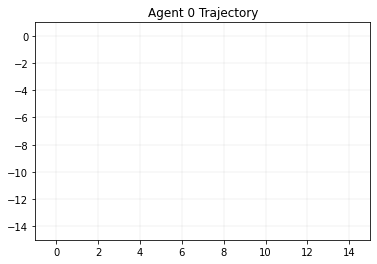

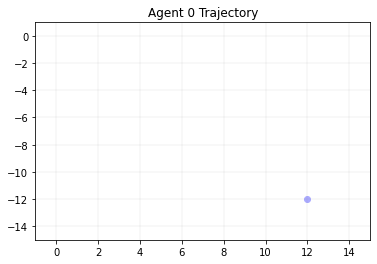

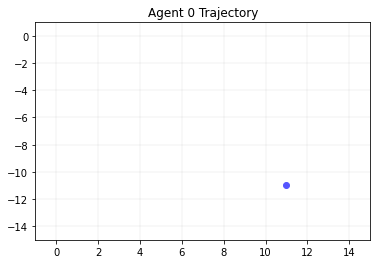

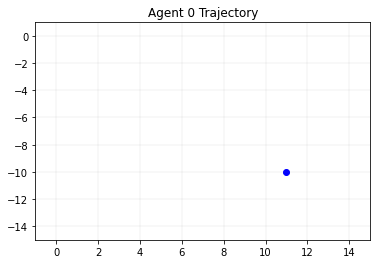

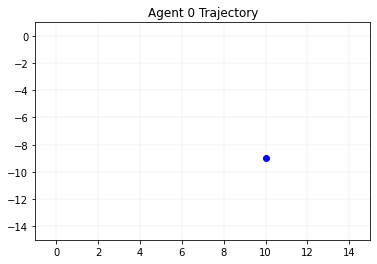

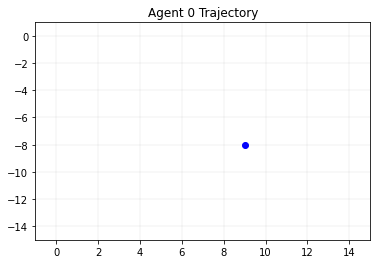

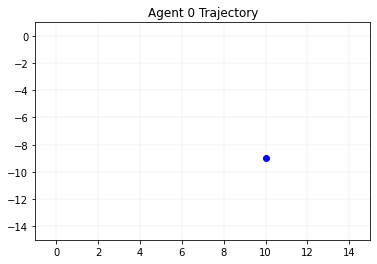

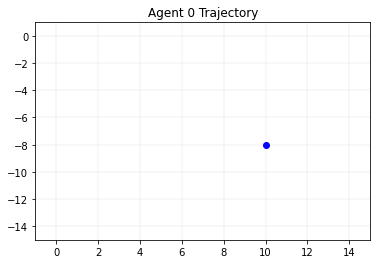

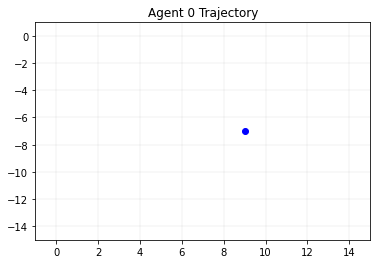

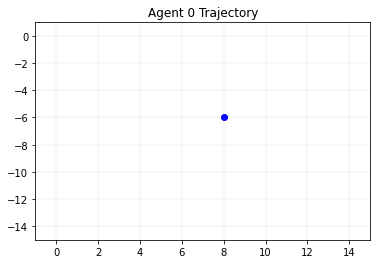

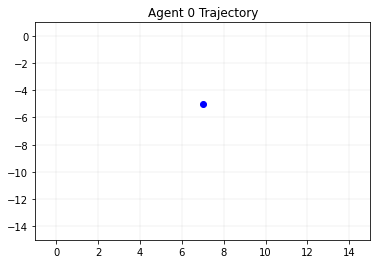

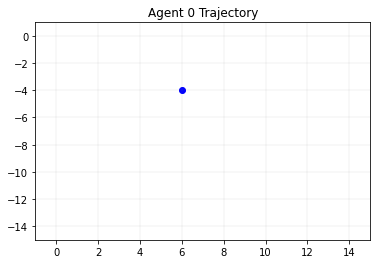

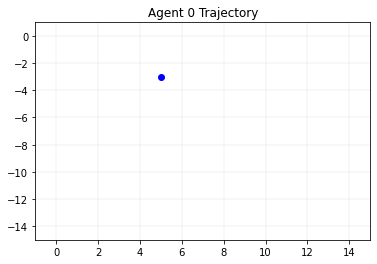

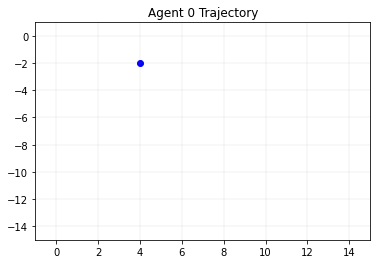

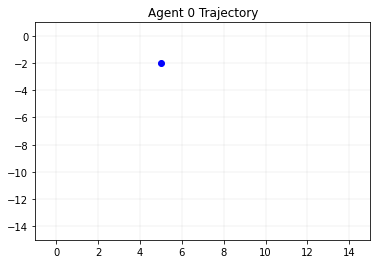

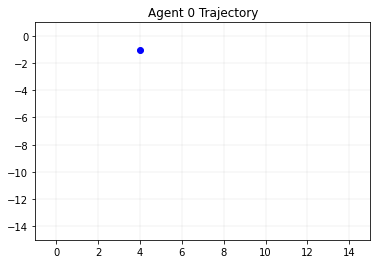

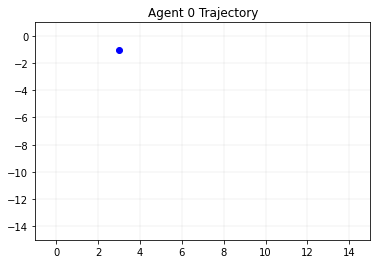

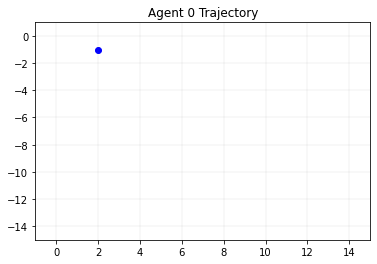

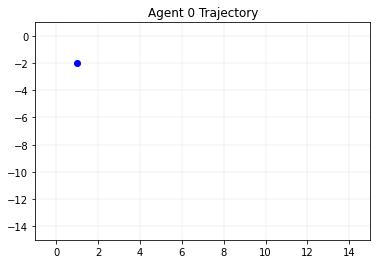

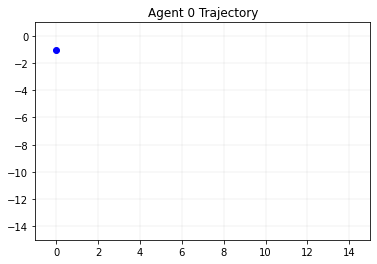

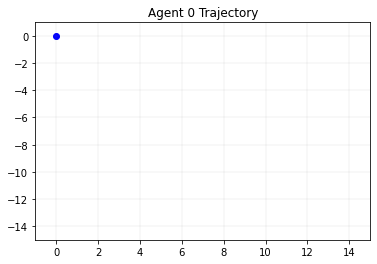

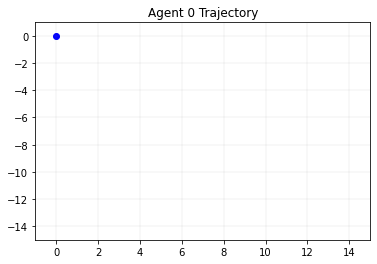

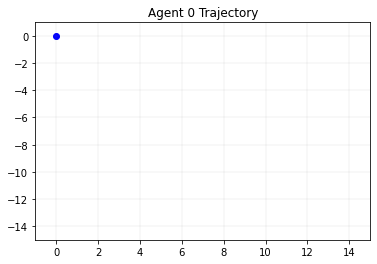

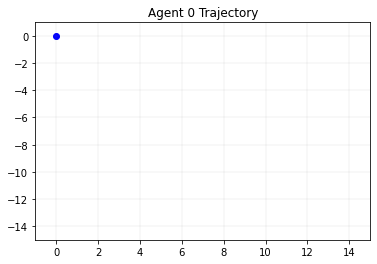

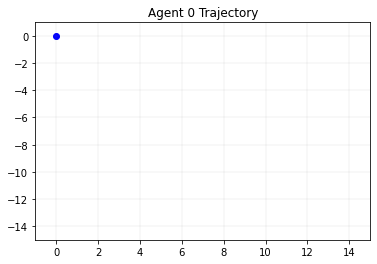

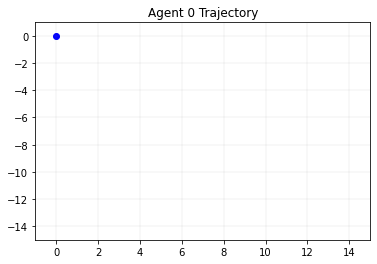

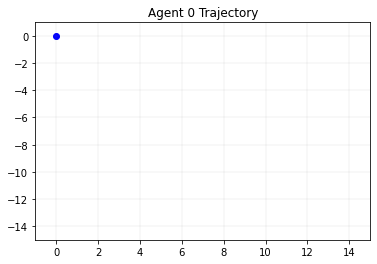

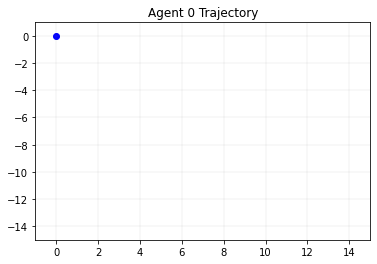

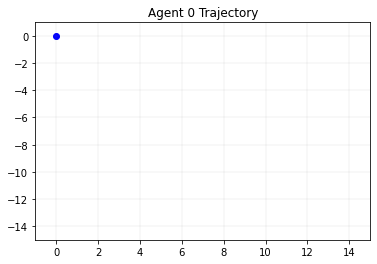

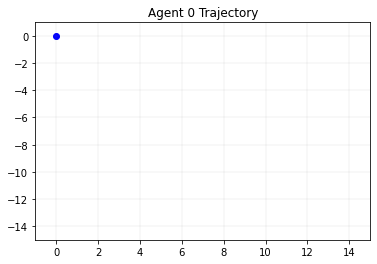

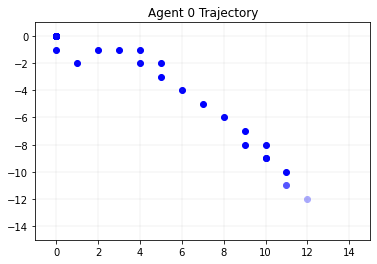

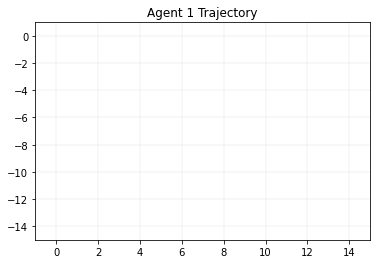

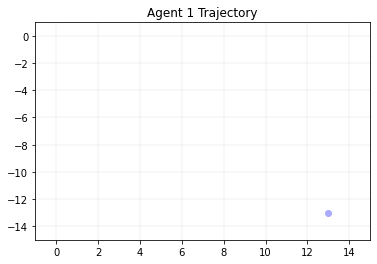

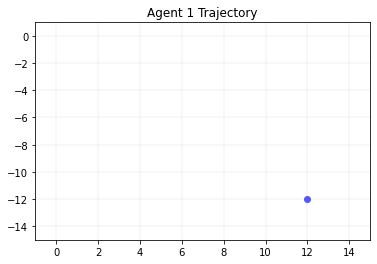

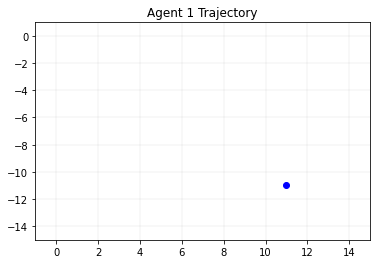

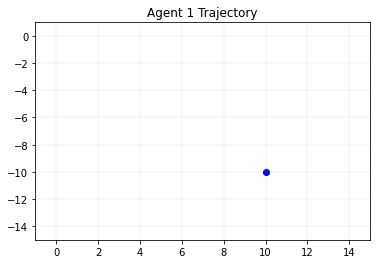

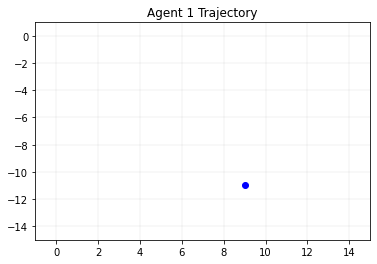

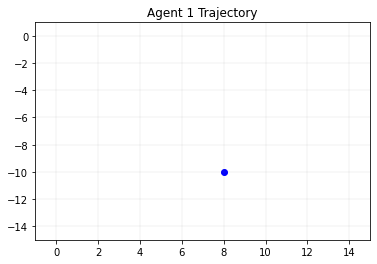

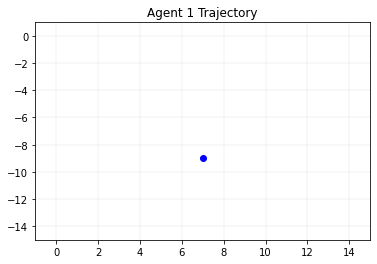

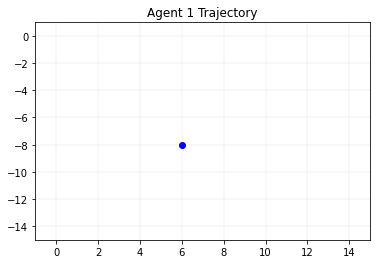

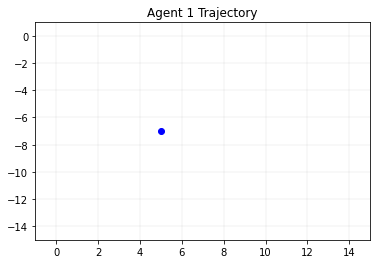

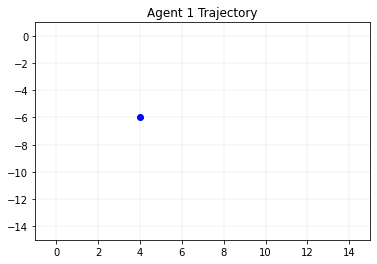

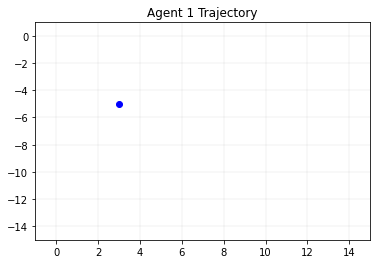

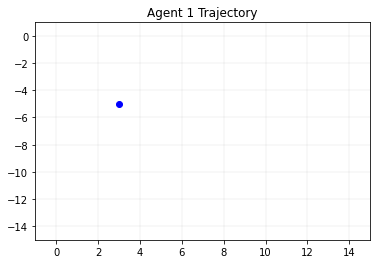

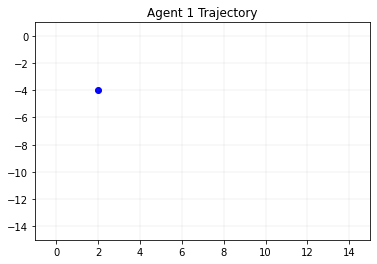

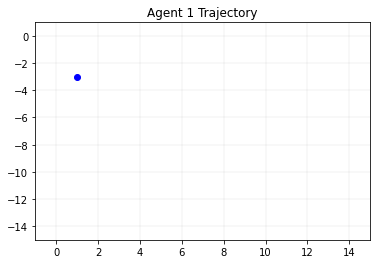

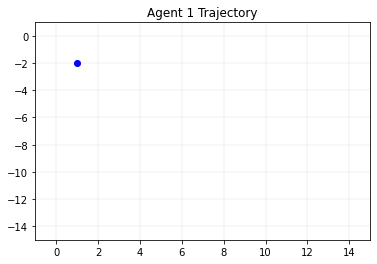

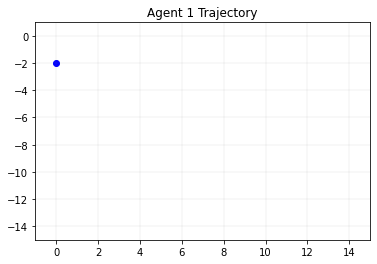

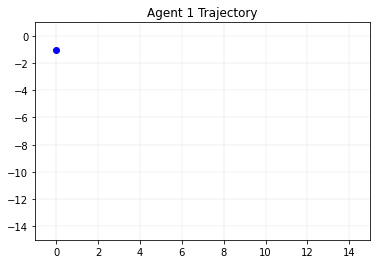

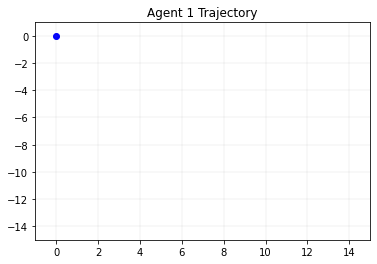

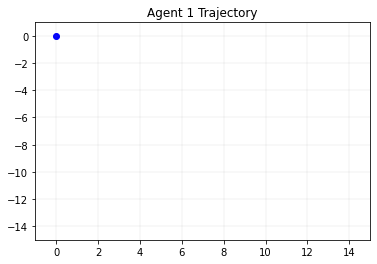

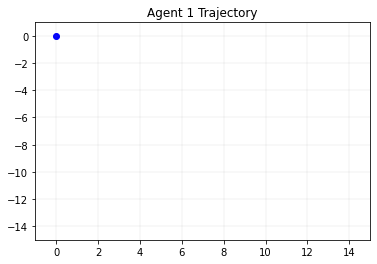

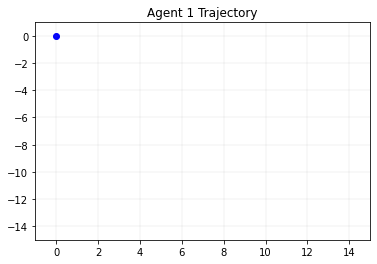

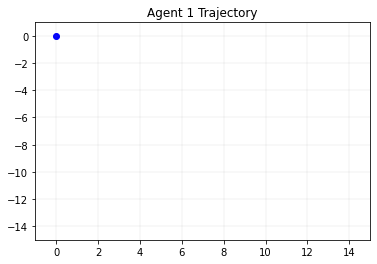

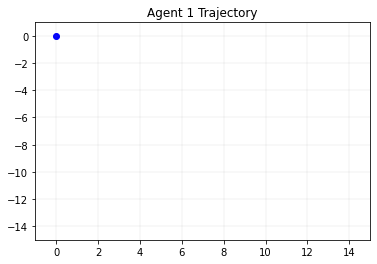

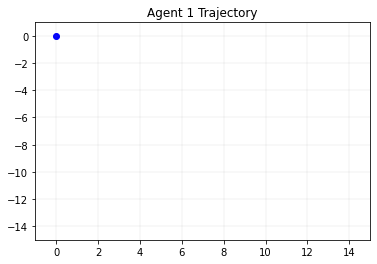

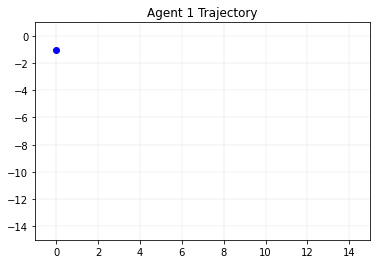

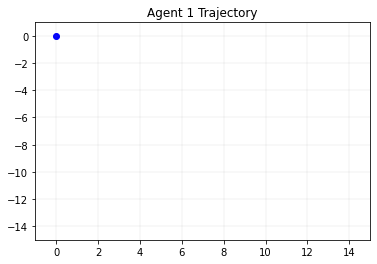

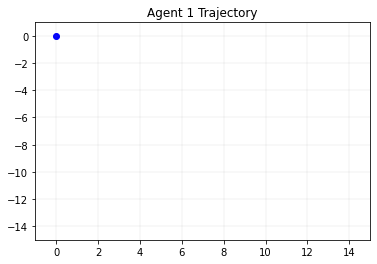

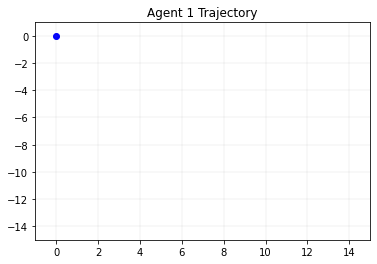

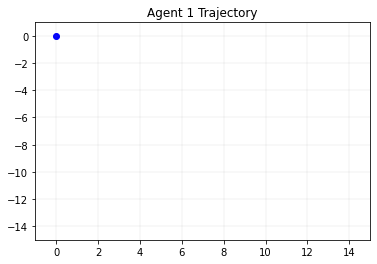

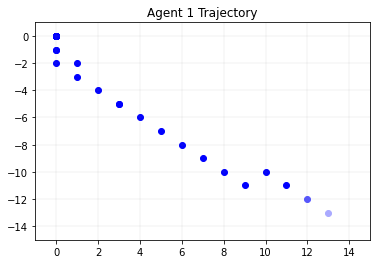

In [12]:
plot_trajectory(0)
plot_trajectory(1)